## Lily Silva Ardiani - ADA LOVELACE Group


# This was our Final Project from Indonesia AI Computer Vision Bootcamp 2

 We used **Enteroscope Biopsy Histopathological Hematoxylin and Eosin Image Dataset for Image Segmentation Tasks (EBHI-Seg)**

 The Dataset is available for public, and downloaded from https://figshare.com/articles/dataset/EBHISEG/21540159/1

 Shi L, Li X, Hu W, Chen H, Chen J, Fan Z, Gao M, Jing Y, Lu G, Ma D, Ma Z, Meng Q, Tang D, Sun H, Grzegorzek M, Qi S, Teng Y, Li C. EBHI-Seg: A novel enteroscope biopsy histopathological hematoxylin and eosin image dataset for image segmentation tasks. Front Med (Lausanne). 2023 Jan 24;10:1114673. doi: 10.3389/fmed.2023.1114673. PMID: 36760405; PMCID: PMC9902656.

In [ ]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 48.2 MB/s eta 0:00:00


In [ ]:
!pip install torchinfo


In [ ]:
import pandas as pd
import numpy as np
import os
import json
import cv2
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as utils
import torchvision.transforms.functional as tf
import torch.nn.functional as f
import torchvision
import torchmetrics as metrics
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from PIL import Image, ImageColor
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from pathlib import Path
#from models.unetArch import UNet, dice_loss, multiclass_dice_coef
from torchmetrics.functional.classification import multilabel_precision, multilabel_recall
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/EBHI-SEG.zip'
destination_folder = '/content/drive/MyDrive/EBHI-SEG'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
colors = [
    (255, 255, 255), # Background (white)
    (0, 0, 255),    # Normal (blue)
    (51, 255, 153),  # Polyp (cyanic green)
    (204, 255, 51),  # Serrated adenoma (yelowish green)
    (255, 255, 0),  # Low-grade IN (yellow)
    (255, 153, 0), # High-grade IN (orange)
    (204, 51, 0), # Adenocarcinoma (red)
]

# Data preps(System)

In [ ]:
trainDf = pd.read_csv('traindata.csv')
valDf = pd.read_csv('valdata.csv')
testDf = pd.read_csv('testdata.csv')

In [ ]:
trainDf['Path'] = trainDf['Path'].str.strip()

In [ ]:
trainDf

Path
0        EBHI-SEG/Polyp/image/GTXC2110503-1-400-002.png
1     EBHI-SEG/Low-grade IN/image/GTDC2101366-1-400-...
2     EBHI-SEG/Adenocarcinoma/image/GTXC2012151-2-40...
3          EBHI-SEG/Polyp/image/GT2012191-1-400-002.png
4     EBHI-SEG/Adenocarcinoma/image/GTXC2015349-2-40...
...                                                 ...
1553      EBHI-SEG/Normal/image/GT2100144-1-400-004.png
1554  EBHI-SEG/Adenocarcinoma/image/GTXC2110135-2-40...
1555  EBHI-SEG/Adenocarcinoma/image/GT2001849-1-400-...
1556  EBHI-SEG/Adenocarcinoma/image/GTXC2015413-3-40...
1557  EBHI-SEG/Adenocarcinoma/image/GTxc2013980-1-40...

[1558 rows x 1 columns]

In [ ]:
dataDir = Path('EBHI-SEG')

classNames = [classes for classes in os.listdir(dataDir) if os.path.isdir(os.path.join(dataDir, classes))]
imageList = []
labelList = []
classList = []
splitClass = []
trainList = trainDf['Path'].tolist()
valList = valDf['Path'].tolist()
testList = testDf['Path'].tolist()

for className in classNames:
    classDir = os.path.join(dataDir, className)
    imageDir = os.path.join(classDir, 'image')
    labelDir = os.path.join(classDir, 'label')
    imagePath = [file for file in os.listdir(imageDir)]
    labelPath = [file for file in os.listdir(labelDir)]

    for img in imagePath:
        if img in labelPath:
            imageList.append(os.path.join(imageDir, img))
            labelList.append(os.path.join(labelDir, img))
            classList.append(className)
            if os.path.join(imageDir, img) in trainList:
                splitClass.append('train')
            elif os.path.join(imageDir, img) in valList:
                splitClass.append('validation')
            else:
                splitClass.append('testing')

In [ ]:
df = pd.DataFrame({'image' : imageList, 'label' : labelList, 'class' : classList, 'split' : splitClass})

In [ ]:
df['split'].unique()

array(['train', 'validation', 'testing'], dtype=object)

In [ ]:
for folder in dataDir.iterdir():
    if folder.is_dir():
        for folder2 in folder.iterdir():
            if folder2.is_dir():
                print(folder.name)
                print(folder2.name)
                print(len(os.listdir(folder2)))

Adenocarcinoma
label
795
Adenocarcinoma
image
795
High-grade IN
label
186
High-grade IN
image
186
Normal
label
76
Normal
image
76
Polyp
label
474
Polyp
image
474
Low-grade IN
label
637
Low-grade IN
image
639
Serrated adenoma
label
58
Serrated adenoma
image
58


In [ ]:
df.to_csv('imageLabel.csv', index=False)

# Data preps

In [ ]:
df = pd.read_csv('imageLabel.csv')
df

image  \
0     EBHI-SEG/Adenocarcinoma/image/GT2014662-3-400-...   
1     EBHI-SEG/Adenocarcinoma/image/GT2014662-3-400-...   
2     EBHI-SEG/Adenocarcinoma/image/GT2014789-2-400-...   
3     EBHI-SEG/Adenocarcinoma/image/GTxc2012888-1-40...   
4     EBHI-SEG/Adenocarcinoma/image/GTxc2014144-4-40...   
...                                                 ...   
2221  EBHI-SEG/Serrated adenoma/image/GTXC2014151-2-...   
2222  EBHI-SEG/Serrated adenoma/image/GTXC2014129-4-...   
2223  EBHI-SEG/Serrated adenoma/image/GTXC2014129-2-...   
2224  EBHI-SEG/Serrated adenoma/image/GTDC2102188-2-...   
2225  EBHI-SEG/Serrated adenoma/image/GTxc2012521-2-...   

                                                  label             class  \
0     EBHI-SEG/Adenocarcinoma/label/GT2014662-3-400-...    Adenocarcinoma   
1     EBHI-SEG/Adenocarcinoma/label/GT2014662-3-400-...    Adenocarcinoma   
2     EBHI-SEG/Adenocarcinoma/label/GT2014789-2-400-...    Adenocarcinoma   
3     EBHI-SEG/Adenocarcinoma/label/GTxc2012888-1-40...    Adenocarcinoma   
4     EBHI-SEG/Adenocarcinoma/label/GTxc2014144-4-40...    Adenocarcinoma   
...                                                 ...               ...   
2221  EBHI-SEG/Serrated adenoma/label/GTXC2014151-2-...  Serrated adenoma   
2222  EBHI-SEG/Serrated adenoma/label/GTXC2014129-4-...  Serrated adenoma   
2223  EBHI-SEG/Serrated adenoma/label/GTXC2014129-2-...  Serrated adenoma   
2224  EBHI-SEG/Serrated adenoma/label/GTDC2102188-2-...  Serrated adenoma   
2225  EBHI-SEG/Serrated adenoma/label/GTxc2012521-2-...  Serrated adenoma   

           split  
0          train  
1     validation  
2          train  
3          train  
4          train  
...          ...  
2221       train  
2222  validation  
2223       train  
2224       train  
2225       train  

[2226 rows x 4 columns]

In [ ]:
df[df['split'] == 'train']

image  \
0     EBHI-SEG/Adenocarcinoma/image/GT2014662-3-400-...   
2     EBHI-SEG/Adenocarcinoma/image/GT2014789-2-400-...   
3     EBHI-SEG/Adenocarcinoma/image/GTxc2012888-1-40...   
4     EBHI-SEG/Adenocarcinoma/image/GTxc2014144-4-40...   
5     EBHI-SEG/Adenocarcinoma/image/GT2015138-1-400-...   
...                                                 ...   
2219  EBHI-SEG/Serrated adenoma/image/GTDC2102188-2-...   
2221  EBHI-SEG/Serrated adenoma/image/GTXC2014151-2-...   
2223  EBHI-SEG/Serrated adenoma/image/GTXC2014129-2-...   
2224  EBHI-SEG/Serrated adenoma/image/GTDC2102188-2-...   
2225  EBHI-SEG/Serrated adenoma/image/GTxc2012521-2-...   

                                                  label             class  \
0     EBHI-SEG/Adenocarcinoma/label/GT2014662-3-400-...    Adenocarcinoma   
2     EBHI-SEG/Adenocarcinoma/label/GT2014789-2-400-...    Adenocarcinoma   
3     EBHI-SEG/Adenocarcinoma/label/GTxc2012888-1-40...    Adenocarcinoma   
4     EBHI-SEG/Adenocarcinoma/label/GTxc2014144-4-40...    Adenocarcinoma   
5     EBHI-SEG/Adenocarcinoma/label/GT2015138-1-400-...    Adenocarcinoma   
...                                                 ...               ...   
2219  EBHI-SEG/Serrated adenoma/label/GTDC2102188-2-...  Serrated adenoma   
2221  EBHI-SEG/Serrated adenoma/label/GTXC2014151-2-...  Serrated adenoma   
2223  EBHI-SEG/Serrated adenoma/label/GTXC2014129-2-...  Serrated adenoma   
2224  EBHI-SEG/Serrated adenoma/label/GTDC2102188-2-...  Serrated adenoma   
2225  EBHI-SEG/Serrated adenoma/label/GTxc2012521-2-...  Serrated adenoma   

      split  
0     train  
2     train  
3     train  
4     train  
5     train  
...     ...  
2219  train  
2221  train  
2223  train  
2224  train  
2225  train  

[1558 rows x 4 columns]

In [ ]:
df[df['split'] == 'validation']

image  \
1     EBHI-SEG/Adenocarcinoma/image/GT2014662-3-400-...   
6     EBHI-SEG/Adenocarcinoma/image/GTXC2014065-1-40...   
7     EBHI-SEG/Adenocarcinoma/image/GTxc2012962-1-40...   
19    EBHI-SEG/Adenocarcinoma/image/GTXC2013391-1-40...   
27    EBHI-SEG/Adenocarcinoma/image/GTxc2014065-1-40...   
...                                                 ...   
2211  EBHI-SEG/Serrated adenoma/image/GTXC2015335-3-...   
2212  EBHI-SEG/Serrated adenoma/image/GTXC2015335-3-...   
2217  EBHI-SEG/Serrated adenoma/image/GTDC2102188-2-...   
2220  EBHI-SEG/Serrated adenoma/image/GTXC2014129-4-...   
2222  EBHI-SEG/Serrated adenoma/image/GTXC2014129-4-...   

                                                  label             class  \
1     EBHI-SEG/Adenocarcinoma/label/GT2014662-3-400-...    Adenocarcinoma   
6     EBHI-SEG/Adenocarcinoma/label/GTXC2014065-1-40...    Adenocarcinoma   
7     EBHI-SEG/Adenocarcinoma/label/GTxc2012962-1-40...    Adenocarcinoma   
19    EBHI-SEG/Adenocarcinoma/label/GTXC2013391-1-40...    Adenocarcinoma   
27    EBHI-SEG/Adenocarcinoma/label/GTxc2014065-1-40...    Adenocarcinoma   
...                                                 ...               ...   
2211  EBHI-SEG/Serrated adenoma/label/GTXC2015335-3-...  Serrated adenoma   
2212  EBHI-SEG/Serrated adenoma/label/GTXC2015335-3-...  Serrated adenoma   
2217  EBHI-SEG/Serrated adenoma/label/GTDC2102188-2-...  Serrated adenoma   
2220  EBHI-SEG/Serrated adenoma/label/GTXC2014129-4-...  Serrated adenoma   
2222  EBHI-SEG/Serrated adenoma/label/GTXC2014129-4-...  Serrated adenoma   

           split  
1     validation  
6     validation  
7     validation  
19    validation  
27    validation  
...          ...  
2211  validation  
2212  validation  
2217  validation  
2220  validation  
2222  validation  

[447 rows x 4 columns]

In [ ]:
classes = {
    'Normal' : 1,
    'Polyp' : 2,
    'Low-grade IN' : 4,
    'High-grade IN' : 5,
    'Serrated adenoma' : 3,
    'Adenocarcinoma' : 6
}

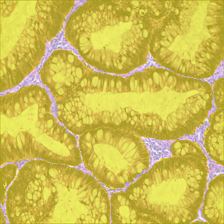

In [ ]:
randidx = np.random.randint(0, len(df))
# Tampilkan salah satu gambar
colorMap = np.array(colors, dtype=np.uint8)
img = Image.open(df.iloc[randidx,0])
lbl = np.array(Image.open(df.iloc[randidx,1]))
lblBin = (lbl > 0).astype(np.uint8) * classes[df.iloc[randidx,2]]
coloredBin = Image.fromarray(colorMap[lblBin]).convert('RGB')
overlay = Image.blend(img, coloredBin, alpha=.6)
overlay

In [ ]:
df['class'].unique()

array(['Adenocarcinoma', 'High-grade IN', 'Normal', 'Polyp',
       'Low-grade IN', 'Serrated adenoma'], dtype=object)

In [ ]:
class customDataset(Dataset):
    def __init__(self, imageList, labelList, classList, classDict, transforms=None):
        assert len(imageList) == len(labelList) and len(imageList) == len(classList) and len(labelList) == len(classList), '3 of the list are not the same length'
        self.imageList = imageList
        self.labelList = labelList
        self.classList = classList
        self.classDict = classDict
        self.transforms = transforms
    def __len__(self):
        return len(self.imageList)
    def __getitem__(self, index):
        image = np.array(Image.open(self.imageList[index]))
        mask = np.array(Image.open(self.labelList[index]))
        mask = (mask > 0).astype(np.uint8) * self.classDict[self.classList[index]]
        if self.transforms:
            transformed = self.transforms(image=image, mask=mask)
            imgAug = transformed['image'].contiguous()
            maskAug = transformed['mask'].contiguous()
            return imgAug, maskAug
        image = torch.as_tensor(image).float().contiguous()
        mask = torch.as_tensor(mask).long().contiguous()
        return image, mask

class dataModule(pl.LightningDataModule):
    def __init__(self, df, classDict, batchSize):
        super().__init__()
        self.df = df
        self.batchSize = batchSize
        self.classDict = classDict
    def prepare_data(self):
        #No data download, so we pass this
        pass
    def _getTransform(self,train=True):
        if train:
            return A.Compose([
                A.OneOf([
                    A.VerticalFlip(),
                    A.HorizontalFlip(),
                    A.RandomRotate90(),
                ], p=.5),
                ToTensorV2()
            ])
        return A.Compose([
            ToTensorV2()
        ])
    def setup(self, stage: str):
        trainTransform = self._getTransform()
        valTransform = self._getTransform(False)
        self.trainingSet = customDataset(df[df['split'] == 'train']['image'].tolist(), df[df['split'] == 'train']['label'].tolist(), df[df['split'] == 'train']['class'].tolist(), classDict=self.classDict, transforms=trainTransform)
        self.valSet = customDataset(df[df['split'] == 'validation']['image'].tolist(), df[df['split'] == 'validation']['label'].tolist(), df[df['split'] == 'validation']['class'].tolist(), classDict=self.classDict, transforms=valTransform)
        self.testSet = customDataset(df[df['split'] == 'testing']['image'].tolist(), df[df['split'] == 'testing']['label'].tolist(), df[df['split'] == 'testing']['class'].tolist(), classDict=self.classDict, transforms=valTransform)
    def train_dataloader(self):
        return DataLoader(self.trainingSet, batch_size=self.batchSize, num_workers=4, drop_last=True, pin_memory=True, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self.valSet, batch_size=self.batchSize, num_workers=4, drop_last=True, pin_memory=True, shuffle=False)
    def predict_dataloader(self):
        return DataLoader(self.testSet, batch_size=self.batchSize, num_workers=4, drop_last=True, pin_memory=True, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary


class ResidualDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualDoubleConv, self).__init__()
        self.resconv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        residual = self.resconv(x)  # Save the input as the residual connection
        x = self.double_conv(x)
        x = x + residual  # Add the residual connection
        return x


class ResDown(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.maxpool_conv = nn.Sequential(
            # Max-pooling untuk downsampling
            nn.MaxPool2d(2),
            # Dua lapisan konvolusi berurutan
            ResidualDoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class ResUp(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        if bilinear:
            # Upsampling menggunakan bilinear interpolation
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = ResidualDoubleConv(in_channels, out_channels // 2)
        else:
            # Upsampling menggunakan konvolusi transpose
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = ResidualDoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # Padding untuk mengubah ukuran x1 agar sesuai dengan x2
        x1 = F.pad(x1, [diffX // 2, diffX - diffX //
                   2, diffY // 2, diffY - diffY // 2])

        # Konkatensis x1 dan x2, lalu terapkan dua lapisan konvolusi
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        # Lapisan konvolusi 1x1 untuk output
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


if __name__ == '__main__':
    x = torch.rand(1,3,10,10)
    resblock = ResidualDoubleConv(3,10)
    print(resblock(x).size())
    downcon = ResDown(10,20)
    print(downcon(resblock(x)).size())

torch.Size([1, 10, 10, 10])
torch.Size([1, 20, 5, 5])


In [ ]:
import torch
from torch import Tensor

# Fungsi untuk menghitung koefisien DICE antara dua tensor input dan target.


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Memastikan ukuran input dan target sama.
    assert input.size() == target.size()
    # Memastikan input adalah tensor 3D atau tidak mengurangi dimensi batch jika tidak diizinkan.
    assert input.dim() == 3 or not reduce_batch_first

    # Menentukan dimensi yang akan dihitung untuk DICE.
    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    # Menghitung intersection (2 * jumlah elemen positif yang cocok).
    inter = 2 * (input * target).sum(dim=sum_dim)

    # Menghitung jumlah elemen positif pada input dan target.
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)

    # Menghindari pembagian oleh nol dengan menggantikan nol dalam sets_sum dengan inter.
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    # Menghitung koefisien DICE dengan menambahkan epsilon untuk menghindari pembagian oleh nol.
    dice = (inter + epsilon) / (sets_sum + epsilon)

    # Mengembalikan rata-rata koefisien DICE.
    return dice.mean()

# Fungsi untuk menghitung koefisien DICE multikelas antara dua tensor input dan target.


def multiclass_dice_coef(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Menggunakan fungsi dice_coeff setelah meratakan (flatten) tensor input dan target.
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)

# Fungsi untuk menghitung loss (kehilangan) berdasarkan koefisien DICE, dengan opsi multikelas.


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Memilih fungsi yang sesuai berdasarkan apakah multikelas diaktifkan.
    fn = multiclass_dice_coef if multiclass else dice_coeff
    # Loss DICE adalah 1 dikurangi nilai koefisien DICE yang dihitung.
    return 1 - fn(input, target, reduce_batch_first=True)

In [ ]:
class ResUNet(nn.Module):
    def __init__(self, n_channels, n_classes, init_filter=64, bilinear=False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Definisi komponen U-Net
        self.inputTensor = (ResidualDoubleConv(n_channels, init_filter))
        self.down1 = (ResDown(init_filter, init_filter*2))
        self.down2 = (ResDown(init_filter*2, init_filter*4))
        self.down3 = (ResDown(init_filter*4, init_filter*8))
        factor = 2 if bilinear else 1
        self.down4 = (ResDown(init_filter*8, init_filter*16 // factor))
        self.up1 = (ResUp(init_filter*16, init_filter*8 // factor, bilinear))
        self.up2 = (ResUp(init_filter*8, init_filter*4 // factor, bilinear))
        self.up3 = (ResUp(init_filter*4, init_filter*2 // factor, bilinear))
        self.up4 = (ResUp(init_filter*2, init_filter, bilinear))
        self.outputTensor = (OutConv(init_filter, n_classes))

    def forward(self, x):
        x1 = self.inputTensor(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outputTensor(x)
        return logits

    def use_checkpointing(self):
        # Menerapkan checkpointing di beberapa lapisan.
        self.inputTensor = torch.utils.checkpoint(self.inputTensor)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outputTensor = torch.utils.checkpoint(self.outputTensor)

if __name__ == "__main__":
    # Instantiate the model and display the summary
    model = ResUNet(n_channels=3, n_classes=7, init_filter=8)
    summary(model, input_size=(1,3,256,256))

In [ ]:
model = ResUNet(n_channels=3, n_classes=5)
summary(model, input_size=(1,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
ResUNet                                       [1, 5, 224, 224]          --
├─ResidualDoubleConv: 1-1                     [1, 64, 224, 224]         --
│    └─Conv2d: 2-1                            [1, 64, 224, 224]         256
│    └─Sequential: 2-2                        [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-1                       [1, 64, 224, 224]         1,792
│    │    └─BatchNorm2d: 3-2                  [1, 64, 224, 224]         128
│    │    └─ReLU: 3-3                         [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-4                       [1, 64, 224, 224]         36,928
│    │    └─BatchNorm2d: 3-5                  [1, 64, 224, 224]         128
│    │    └─ReLU: 3-6                         [1, 64, 224, 224]         --
├─ResDown: 1-2                                [1, 128, 112, 112]        --
│    └─Sequential: 2-3                        [1, 128, 112, 112]        --
│    │    

In [ ]:
class ResUNetModule(pl.LightningModule):
    def __init__(self, nClasses = 7, lr= 0.01, decay=0):
        super().__init__()
        self.model = ResUNet(n_channels=3, n_classes=nClasses)
        self.nClasses = nClasses
        self.lr = lr
        self.decay = decay
        self.save_hyperparameters()
        self.criterion = nn.CrossEntropyLoss()
    def forward(self, x):
        logits = self.model(x)
        return logits
    def training_step(self, batch, batch_idx):
        img, mask = batch
        img = img.to(device=self.device, dtype=torch.float32, memory_format=torch.channels_last)
        mask = mask.to(device=self.device, dtype=torch.long)
        predMask = self.forward(img)
        loss = self.criterion(predMask, mask)
        loss += dice_loss(f.softmax(predMask, dim=1).float(), f.one_hot(mask, self.nClasses).permute(0, 3, 1, 2).float(), multiclass=True)
        self.log('diceLoss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    def validation_step(self, batch, batch_idx):
        img, mask = batch
        totalN = self.trainer.num_val_batches[0]
        img = img.to(device=self.device, dtype=torch.float32, memory_format=torch.channels_last)
        mask = mask.to(device=self.device, dtype=torch.long)
        assert mask.min() >= 0 and mask.max() < self.nClasses, f'True mask indices should be in [0, {self.nClasses}]'
        predMask = self.forward(img)
        mask = f.one_hot(mask, self.nClasses).permute(0, 3, 1, 2).float()
        predMask = f.one_hot(predMask.argmax(dim=1), self.nClasses).permute(0, 3, 1, 2).float()
        diceScore = multiclass_dice_coef(predMask[:,1:], mask[:, 1:], reduce_batch_first=False)
        self.log('diceScore', diceScore, on_step=False, on_epoch=True, prog_bar=True, reduce_fx=torch.mean)
        return diceScore
    def predict_step(self, batch, batch_idx):
        img, mask = batch
        img = img.to(device =self.device, dtype=torch.float32)
        outputs = self.forward(img)
        predMask = outputs.argmax(dim=1)

        mask = f.one_hot(mask.long(), self.nClasses).permute(0, 3, 1, 2).float()
        predictionMask = f.one_hot(predMask.cpu(), self.nClasses).permute(0, 3, 1, 2).float()

        return img, predMask.long().squeeze().cpu().numpy(), mask, predictionMask
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min')
        return {
            'optimizer' : optimizer,
            'lr_scheduler' : {
                'scheduler' : scheduler,
                'monitor' : 'diceLoss'
            }
        }
        # return optimizer

In [ ]:
dataMod = dataModule(df=df, classDict=classes, batchSize=6)
model = ResUNetModule(lr=0.00001)
lrMonitor = LearningRateMonitor(logging_interval='epoch')
logger = TensorBoardLogger('tb_logs', name='ResUNetSegm')
trainer = pl.Trainer(accelerator='gpu', devices=[0], max_epochs=250, logger=logger, callbacks=[lrMonitor])
trainer.fit(model=model, datamodule=dataMod)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResUNet          | 32.4 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
32.4 M    Trainable params
0         Non-trainable params
32.4 M    Total params
129.759   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=250` reached.


In [ ]:
# Predict only
dataMod1 = dataModule(df=df, classDict=classes, batchSize=6)
model1 = ResUNetModule(lr=0.001)
lrMonitor1 = LearningRateMonitor(logging_interval='epoch')
# logger1 = TensorBoardLogger('tb_logs', name='ResUNetSegm')
trainer1 = pl.Trainer(accelerator='gpu', devices=[0], max_epochs=250, callbacks=[lrMonitor1])
results = trainer1.predict(model=model1, datamodule=dataMod1, ckpt_path='/content/tb_logs/ResUNetSegm/version_0/checkpoints/epoch=249-step=64750.ckpt')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/tb_logs/ResUNetSegm/version_0/checkpoints/epoch=249-step=64750.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/tb_logs/ResUNetSegm/version_0/checkpoints/epoch=249-step=64750.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
results = trainer.predict(model=model, datamodule=dataMod)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
numClasses = [0,1,2,3,4,5,6]

In [ ]:
def mask_to_image(preds, mask_values, colors=colors):
    listOverlay = []

    originalMask = [batch[2] for batch in preds]
    originalMask = torch.stack([orMask for batch in originalMask for orMask in batch])
    predictionMask = [batch[3] for batch in preds]
    predictionMask = torch.stack([preMask for batch in predictionMask for preMask in batch])
    images = [batch[0] for batch in preds]
    images = torch.stack([img for batch in images for img in batch])
    masks = [batch[1] for batch in preds]
    masks = np.array([mask for batch in masks for mask in batch])
    recalls = multilabel_recall(predictionMask, originalMask, num_labels=len(mask_values), average='none')
    precisions = multilabel_precision(predictionMask, originalMask, num_labels=len(mask_values), average='none')
    print(f'recalls = background : {recalls[0]:.2f}, normal : {recalls[1]:.2f}, polyp : {recalls[2]:.2f}, serrated adenoma : {recalls[3]:.2f}, low-grade IN : {recalls[4]:.2f}, high-grade IN : {recalls[5]:.2f}, adenocarcinoma : {recalls[6]:.2f}')
    print(f'precisions = background : {precisions[0]:.2f}, normal : {precisions[1]:.2f}, polyp : {precisions[2]:.2f}, serrated adenoma : {precisions[3]:.2f}, low-grade IN : {precisions[4]:.2f}, high-grade IN : {precisions[5]:.2f}, adenocarcinoma : {precisions[6]:.2f}')
    for img, mask in zip(images, masks):
        if isinstance(mask_values[0], list):
            out = np.zeros((mask.shape[-2], mask.shape[-1], len(mask_values[0])), dtype=np.uint8)
        elif mask_values == [0, 1]:
            out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=bool)
        else:
            out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=np.uint8)

        if mask.ndim == 3:
            mask = np.argmax(mask, axis=0)

        for i, v in enumerate(mask_values):
            out[mask == i] = v

        classColorMap = np.array(colors, dtype=np.uint8)
        realImg = Image.fromarray(img.cpu().permute(1,2,0).numpy().astype(np.uint8))
        annIm = Image.fromarray(classColorMap[out])
        annImage = annIm.convert('RGB')
        overlay = Image.blend(realImg, annImage, alpha=.7)
        listOverlay.append(overlay)
    return listOverlay

In [ ]:
overlay = mask_to_image(results, numClasses, colors=colors)

recalls = background : 0.88, normal : 0.49, polyp : 0.88, serrated adenoma : 0.30, low-grade IN : 0.87, high-grade IN : 0.57, adenocarcinoma : 0.86
precisions = background : 0.90, normal : 0.71, polyp : 0.85, serrated adenoma : 0.34, low-grade IN : 0.90, high-grade IN : 0.54, adenocarcinoma : 0.80


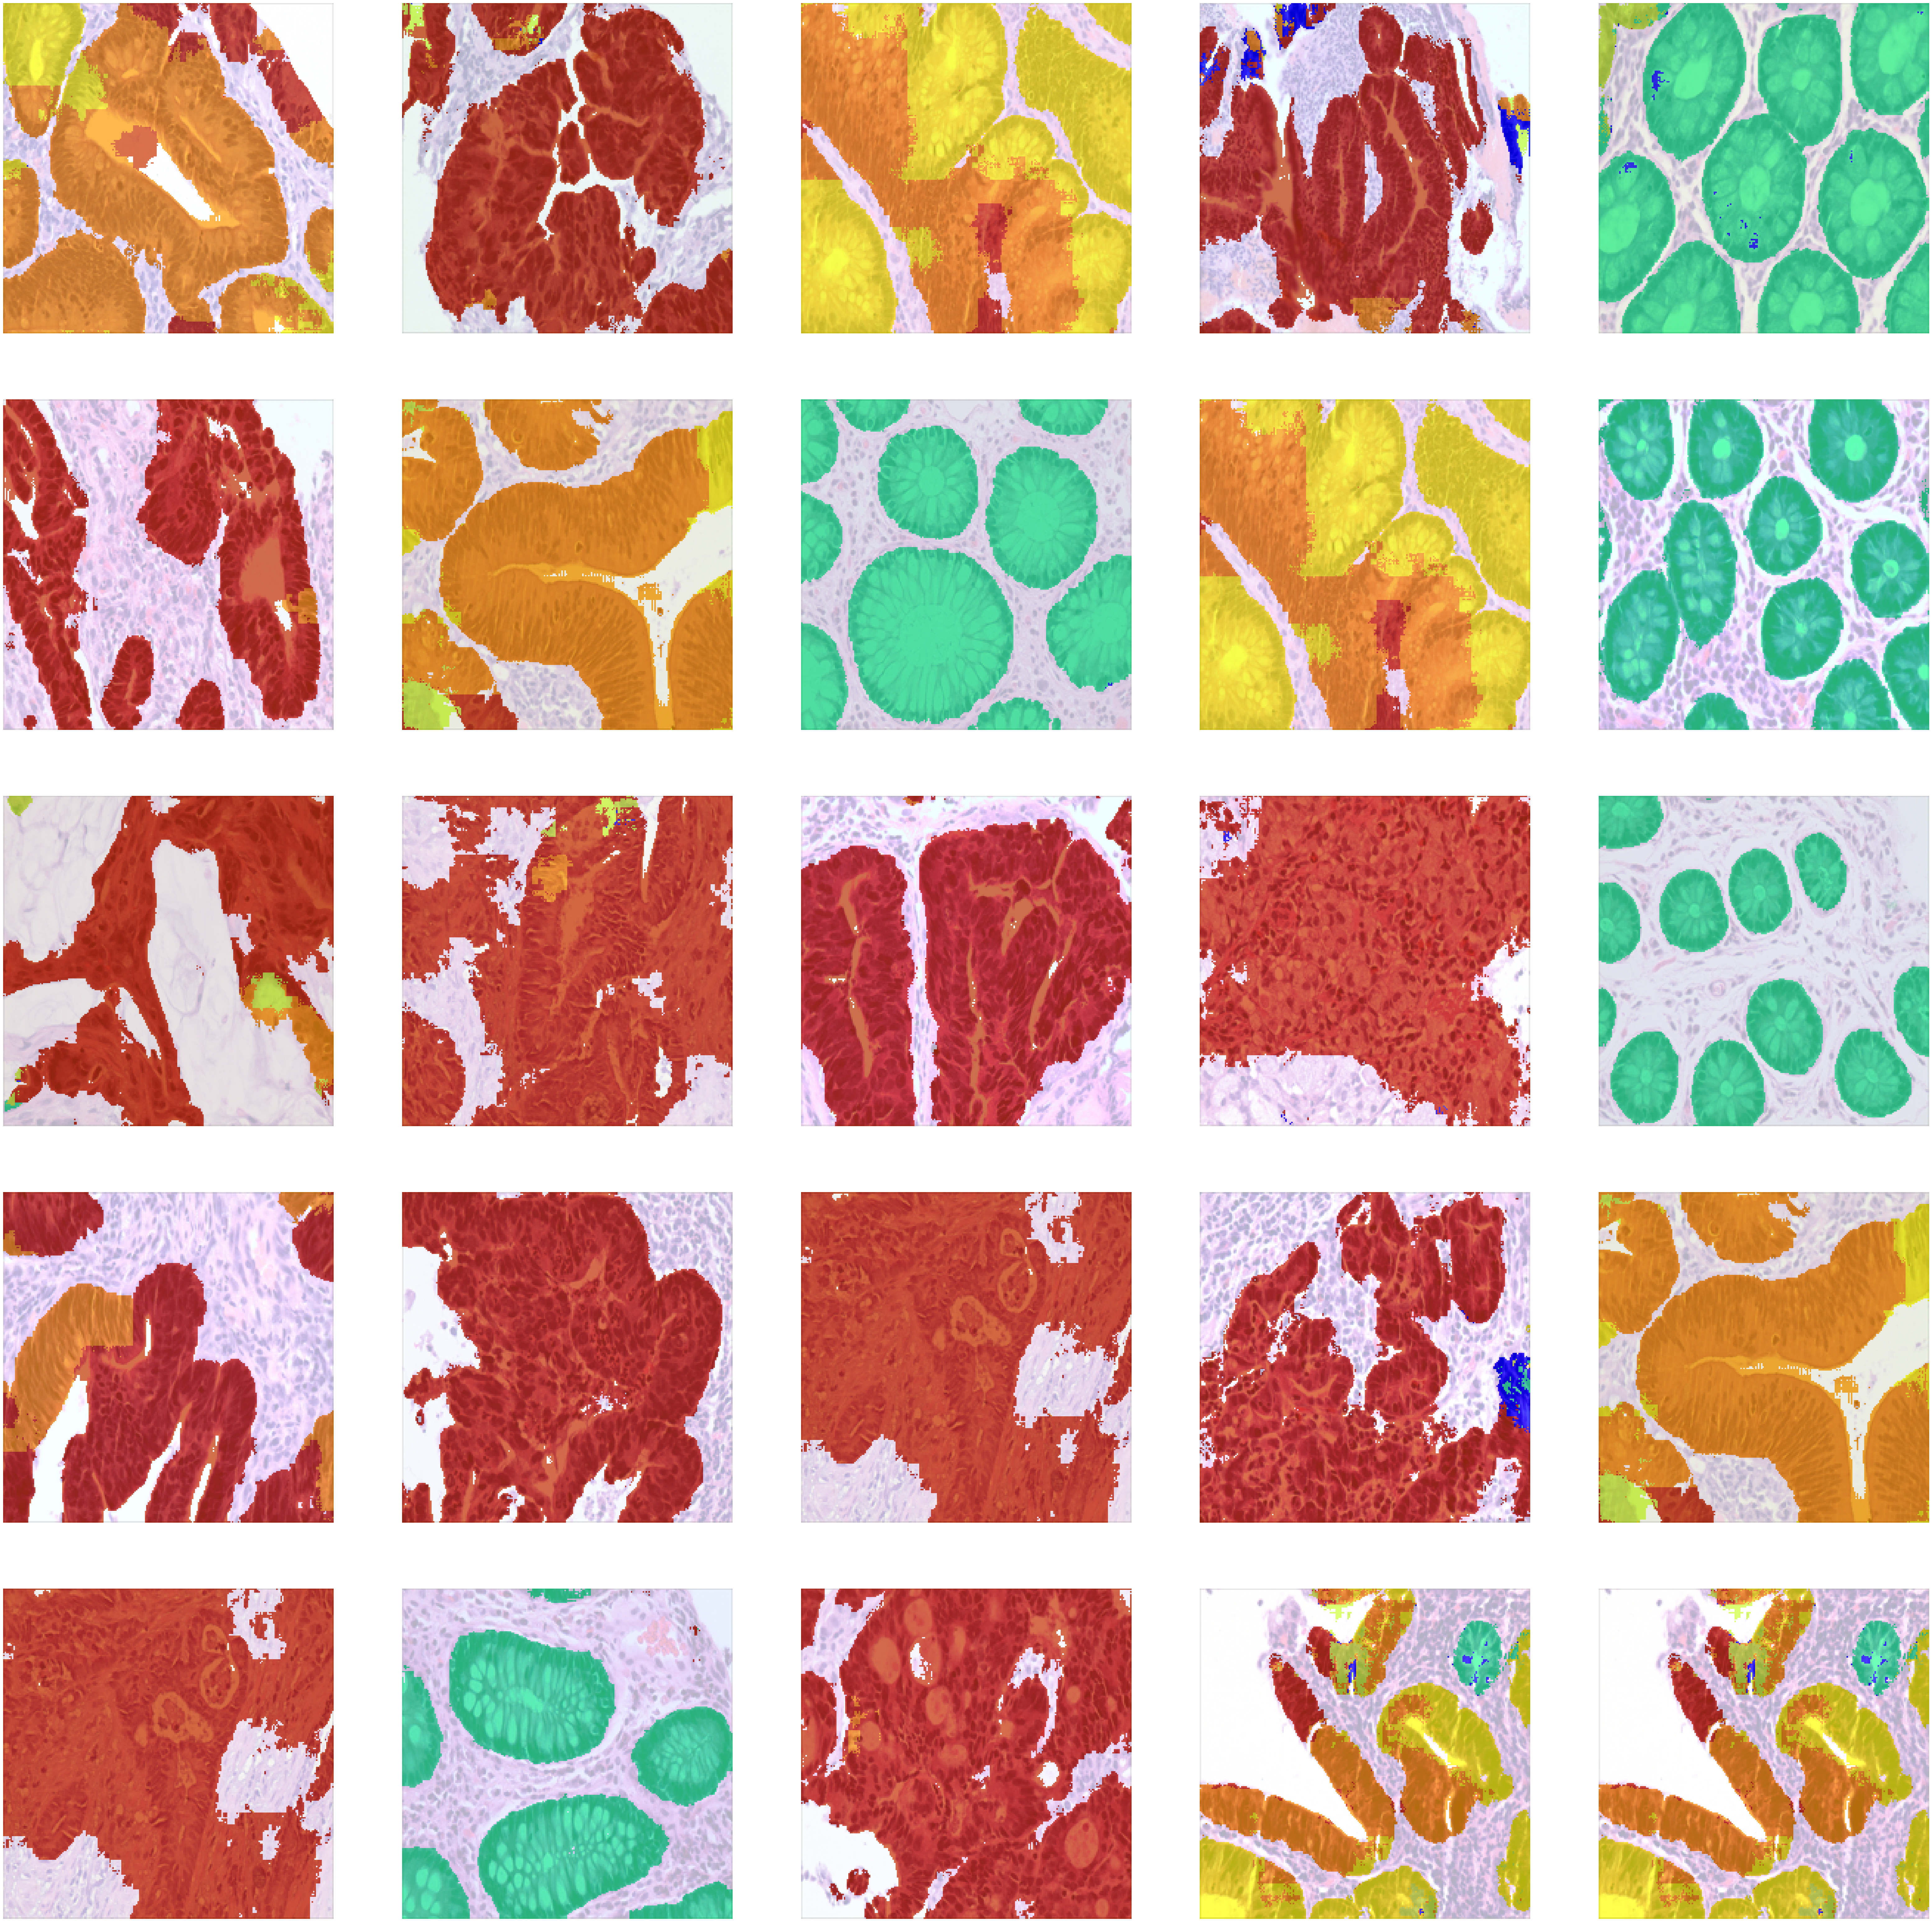

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(80,80))
indices = np.arange(0, len(overlay), step=1)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(overlay[random.choices(indices)[0]])
    ax.axis('off')

plt.show()